# Lab 2. Методы многомерной классификации

## 2.1. Кластерный анализ

### Полезные ссылки:
- [Обзор методов кластеризации в библиотеке scikit-learn](http://scikit-learn.org/stable/modules/clustering.html)
- [Документация к функции scipy.spatial.distance.pdist: различные типы расстояний](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)
- [Открытый курс машинного обучения: обзорная статья по кластеризации](https://habr.com/company/ods/blog/325654/)

- Подключите необходимые библиотеки.

In [329]:
import numpy as np
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import statsmodels.formula.api as smf
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn import linear_model
from statsmodels.graphics.mosaicplot import mosaic

- Загрузите исходные данные согласно варианту.

In [330]:
data = pd.read_csv("dataset_formatted_fixed.csv")

- Подумайте над задачей **кластеризации** ваших объектов. Можете ли вы предположить, какое количество классов должно получиться? Почему?

Так как в данной работе выборкой являются заказы с большим количеством параметров, котроые их определяют, то говорить о выделении конкретных кластеров достаточно сложно. Также тяжело предугадать их количество в связи с тем, что реальное положение дел на рынке может очень отличаться от таргетирования сервиса.

- Применим ли в вашем случае **"наивный" подход к кластеризации**: берём наиболее значимый признак и делим выборку на классы по этому признаку. Затем получившиеся классы делим по значениям второго по важности признака и так далее? Почему? Каковы недостатки этого подхода?

Во первых при "наивной" кластеризации сразу же возникает вопрос какой признак считать наиболее важным, что является достаточно значимым, так как каждый раз получим по сути новую кластеризацию. Недостаток подхода в том, что количество кластеров очень быстро растет, в связи с тем что для каждого признака количество новых ветвей, ограничено лишь мощностью множества на котором определен признак, а часто мы имеем дело с непрерывными данными. Тогда возникает требование объединения параметров в какие-либо группы, но сразу же встает вопрос насколько "правильно" мы можем это сделать, или возникает кластеризация, с которой в принципе не возможно работать.

### 2.1.1. Иерархическая кластеризация

- Перечислите известные вам **иерархические процедуры кластеризации** (лучше со ссылками на их описание).

Среди алгоритмов иерархической кластеризации выделяются два основных типа: восходящие и нисходящие алгоритмы. Нисходящие алгоритмы работают по принципу «сверху-вниз»: в начале все объекты помещаются в один кластер, который затем разбивается на все более мелкие кластеры. Более распространены восходящие алгоритмы, которые в начале работы помещают каждый объект в отдельный кластер, а затем объединяют кластеры во все более крупные, пока все объекты выборки не будут содержаться в одном кластере. Таким образом строится система вложенных разбиений. Результаты таких алгоритмов обычно представляют в виде дерева – дендрограммы. Классический пример такого дерева – классификация животных и растений.
Источник: https://habr.com/post/101338/
Алгоритмы, в свою очередь, подразделяются на агломеративные (объединительные) и дивизивные (разделяющие).
В работах по кластерному анализу описан довольно внушительный ряд способов построения (англ. sorting strategies) дендрограмм:
Метод одиночной связи (англ. single linkage). Также известен, как «метод ближайшего соседа».
Метод полной связи (англ. complete linkage). Также известен, как «метод дальнего соседа».
Метод средней связи (англ. pair-group method using arithmetic averages).
Невзвешенный (англ. unweighted).
Взвешенный (англ. weighted).
Центроидный метод (англ. pair-group method using the centroid average).
Невзвешенный.
Взвешенный (медианный).
Метод Уорда (англ. Ward’s method).
Источник:https://www.wikiwand.com/ru/%D0%98%D0%B5%D1%80%D0%B0%D1%80%D1%85%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F

- В чём основная идея иерархических методов?

Такие методы строят не одно разбиение выборки на непересекающиеся кластеры, а систему вложенных разбиений. Т.о. на выходе мы получаем дерево кластеров, корнем которого является вся выборка, а листьями — наиболее мелкие кластера.

- Нужно ли заранее задавать число классов в иерархических алгоритмах?
- Как определеяется наиболее подходящее число классов по результатам работы?

- Выберите наиболее подходящую **меру различия** (расстояния) между объектами. Вы можете также придумать её самостоятельно, с учётом специфики задачи и предметной области. 
- Проверьте, удовлетовряет ли выбранная мера _аксиомам метрики_.

Так как для исходной выборки плохо представляется возможным кластеризовать полный объем данных (большое количество не значущих данных, которые требуют очистки, налиие большого количества категориальных данных введение метрики между которыми возможно только технически вручную), то мы будем рассматривать задачу кластеризации подвыборки. А именно в исходных данных присутствует информация о транспортных средствах водителей - габариты (ширина (м), высота (м), длина кузова (м)) и грузоподъемность (т). Очевидно, что они имеют некую корреляцию и тем более исходя из структуры предметной области существует отдельные "типы" объектов, которые по сути определяют признаки кластеров и могут быть оценены на совпадение с реальным миром.

In [331]:
def get_data():
    new_data = data.copy()
    # Убираем из таблицы повторы (один и тот же водитель с одним и тем же транспортным средством просматривал несколько заказов)
    new_data = new_data.drop_duplicates(subset=['subdriver_id'], keep='first')
    new_data = new_data[new_data['capacity'] <= 40]
    # Выбираем из исходных данных подвыборку
    new_data = pd.concat([new_data['capacity'], new_data['length'], new_data['height'], new_data['width']], axis=1, keys=['capacity', 'length', 'height', 'width'])
    # Уберем все наблюдения в которых есть недостаток данных хотябы по одному из параметров
    for attribute_name in ['capacity', 'width', 'length', 'height']:
        new_data = new_data[pd.notnull(new_data[attribute_name])]
    # нормализация данных
    return new_data

Теперь перед нами предстала задача выбрать метрику, подходящую . Для выбора метрики воспользуемся cophenetic distance (https://www.wikiwand.com/en/Cophenetic) в случае иерархических методов. И переберем различные встроенные метрики, так как возможно их окажется достаточно и не понадобится вводить свои.

In [332]:
# Вычислим расстояния между каждым набором данных,
# т.е. строками массива data_for_clust
new_data = get_data()
datarium = new_data
# нормализация данных
new_data = (new_data - new_data.min()) / (new_data.max() - new_data.min())
data_dist = sp.spatial.distance.pdist(new_data, 'cityblock')
# data_linkage = sp.cluster.hierarchy.linkage(new_data, method='ward')
# data_linkage = sp.cluster.hierarchy.linkage(data_dist, method='single')
data_linkage = sp.cluster.hierarchy.linkage(data_dist, method='average')
c, coph_dists = sp.cluster.hierarchy.cophenet(data_linkage, data_dist)
print(c)
# Метод average выбран на основе наиболее близкого к 1 cophenetic distance 

0.9573091698796996


- Постройте матрицу расстояний между объектами на основе данной метрики.
- Попробуйте визуализировать эту матрицу (например, с помощью seaborn.heatmap).

capacity    40.0
length      10.0
height      10.0
width       10.0
Name: 36, dtype: float64


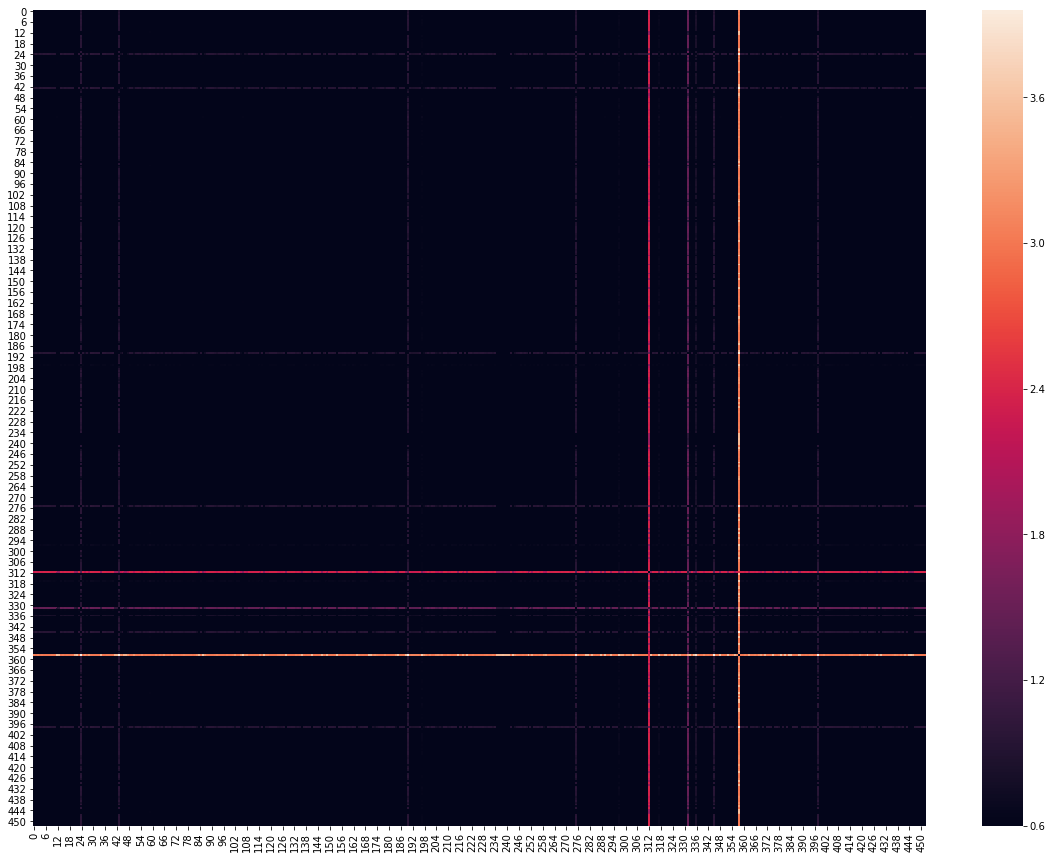

In [333]:
import seaborn as sns;
data_dist_matrix = sp.spatial.distance.squareform(data_dist)
plt.subplots(figsize=(20,15))
sns.heatmap(data_dist_matrix, vmin=0.6)
# Выведем данные хоть одной из выделвшихся машин и убедимся, что данные неадекватны 
print(get_data().iloc[24])

Можно заметить, что без очистки данных матрица расстояний не является показательной, так как по сути показала, что расстояние между выбросами достаточно близко. Можно сделать выводы, что люди чаще всего ошибаются одним способом вводя данные в форму регистрации, что вполне может говорить о том что форма не человекопонятна.

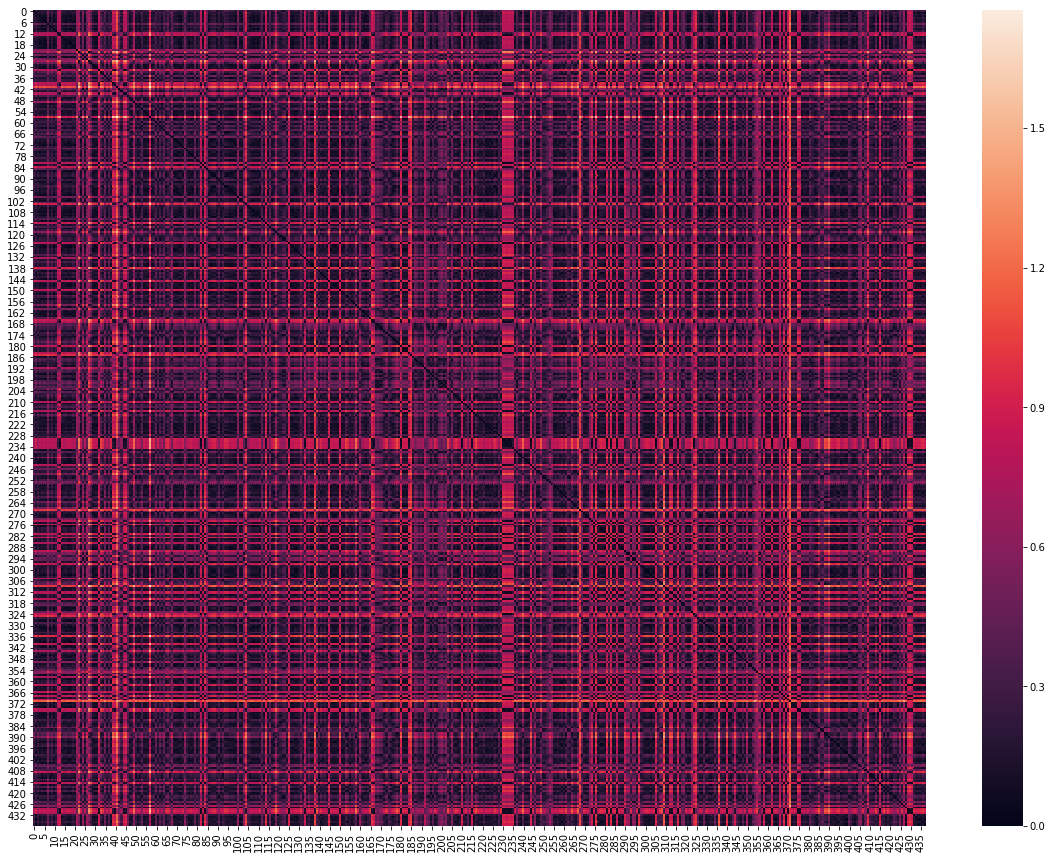

In [334]:
new_data = get_data()
new_data = new_data[new_data['capacity'] <= 40]
new_data = new_data[new_data['width'] <= 3] #new_data['height'] < 3
new_data = new_data[new_data['height'] <= 3] #new_data['height'] < 3
new_data = new_data[new_data['length'] <= 20]
new_data = (new_data - new_data.min()) / (new_data.max() - new_data.min())
data_dist = sp.spatial.distance.pdist(new_data, 'euclidean')
import seaborn as sns;
data_dist_matrix = sp.spatial.distance.squareform(data_dist)
plt.subplots(figsize=(20,15))
sns.heatmap(data_dist_matrix)

Исходя из выше представленной тепловой карты можно лишь о разнородности исходных данных.

- Попробуйте применить к данным один из **иерархических алгоритмов классификации**.

In [335]:
data_linkage

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()
print(datarium.iloc[358])
print(datarium.iloc[312])

capacity       1.5
length      3000.0
height      1500.0
width       2000.0
Name: 970, dtype: float64
capacity      39.0
length       123.0
height      1212.0
width       1212.0
Name: 672, dtype: float64


Получаем достаточно ожидаемую кластеризацию, в которых разъезжающие по дороге грузовики километровой высоты и прочие нереальные машины заняли отдельные кластеры, а адекватные данные в духе типичных ГАЗелей сгруппировали кластер. 
(Визуализация проводилась с упрощением, которое было эмпирически подобрано для наиболее удобной демонстрации).

Построим кластеризацию после очистки с учетом понимания предметной области и отсечения выбросов.

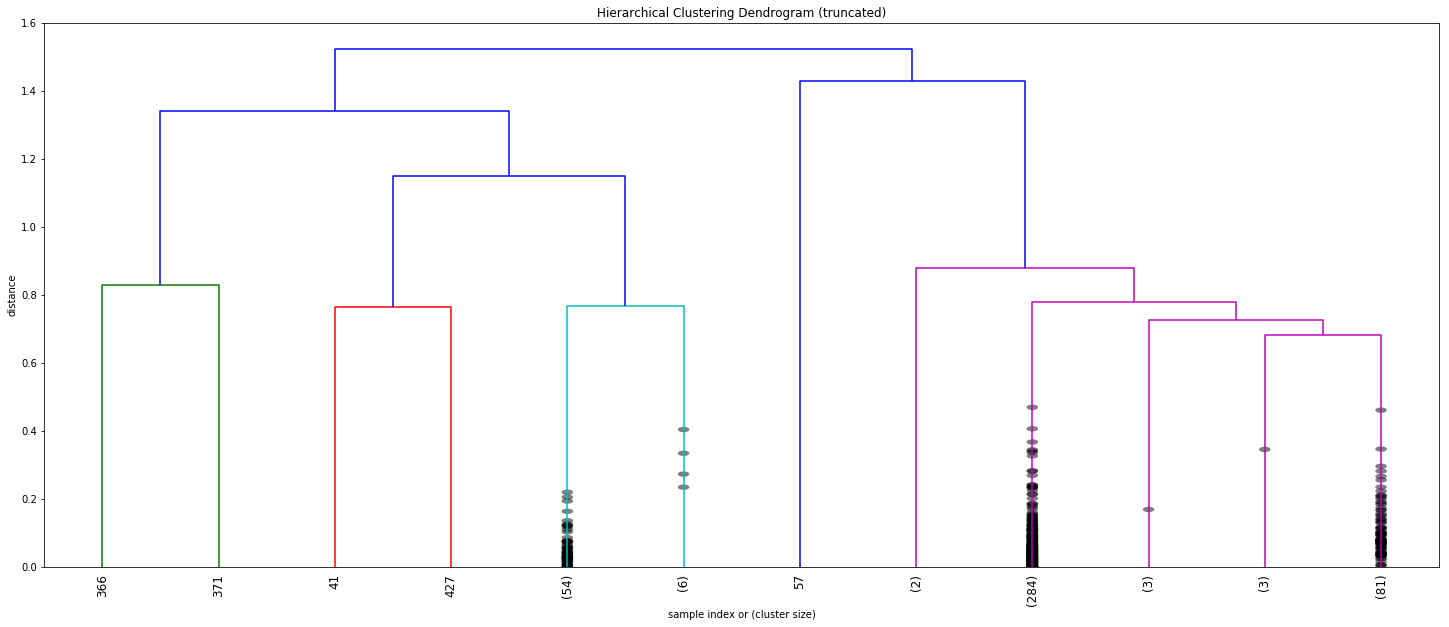

capacity    40.0
length       6.0
height       3.0
width        3.0
Name: 61, dtype: float64


In [336]:
new_data = get_data()
new_data = new_data[new_data['capacity'] <= 40]
new_data = new_data[new_data['width'] <= 3] #new_data['height'] < 3
new_data = new_data[new_data['height'] <= 3] #new_data['height'] < 3
new_data = new_data[new_data['length'] <= 20]
datarium = new_data
new_data = (new_data - new_data.min()) / (new_data.max() - new_data.min())
data_dist = sp.spatial.distance.pdist(new_data, 'cityblock')
data_linkage = sp.cluster.hierarchy.linkage(data_dist, method='average')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()
print(datarium.iloc[41])

Видим более интересные результаты, в котроых 40-тонник, являющийся идеальным транспортным средством для сервиса стал выборосом, а не особо привлекательные 2-3 тонники с малыми габаритами образовали большой кластер.

- Постройте дендрограмму. Сделайте выводы.
- Каковы **преимущества** иерархических методов? Как они проявились конкретно в вашей задаче?
- Каковы **недостатки** иерархических методов? Как они проявились конкретно в вашей задаче?

При большом количестве наблюдений иерархические методы кластерного анализа не пригодны.
Иерархические методы хорошы, когда требуется увидеть полную систему разбиений для небольшого количества наблюдений и возможно ее логичное упрощение при изображении.

### 2.1.2. Итерационные алгоритмы кластеризации

- Перечислите известные вам **итерационные процедуры кластеризации** (лучше со ссылками на их описание).

В итерационных методах заранее требуется знать какое количество классов мы хотим выделить в выборке.
https://ru.coursera.org/learn/sravneniye-sozdaniye-grupp/lecture/vbjzO/4-1-mietod-k-sriednikh

- Применим ли к вашим данным классический **метод k-means**? Почему?

Проблемы классического алгоритма k-means:
* необходимо заранее знать количество кластеров. Требуется наиболее точно приблизить количество кластеров. После этого выполнялся классический алгоритм k-means, который давал более точные результаты. 
* алгоритм очень чувствителен к выбору начальных центров кластеров. Классический вариант подразумевает случайный выбор класторов, что очень часто являлось источником погрешности. Как вариант решения, необходимо проводить исследования объекта для более точного определения центров начальных кластеров. В моем случае на начальном этапе предлагается принимать в качестве центов самые отдаленные точки кластеров. 
* не справляется с задачей, когда объект принадлежит к разным кластерам в равной степени или не принадлежит ни одному.
Последняя проблема не очень ярко выражена в исследуемой предметной области, поэтому классический k-means хоть и не дает отличных результатов, но все же применим.

Попробуйте применить метод k-средних (либо одну из его модификаций) для ваших данных, данных другого варианта либо найденных самостоятельно.

25


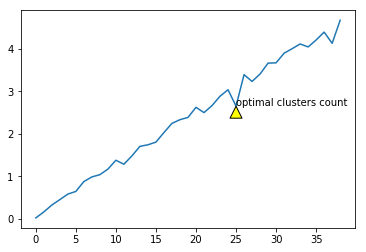

capacity    length    height    width
[[14.8      7.19     2.695    2.495  ]
 [10.       7.55     2.7      2.41667]
 [38.75     8.5      2.25     2.525  ]
 [ 1.28179  3.04643  1.86143  1.82429]
 [ 2.88065  3.06452  1.81129  1.77903]
 [ 5.03158  5.7      2.31763  2.31053]
 [10.       1.       1.       1.     ]
 [ 5.33333  3.61556  1.91111  1.94889]
 [25.28571 13.41429  2.43571  2.35714]
 [23.5      5.5      2.3      2.275  ]
 [ 1.51667  4.075    2.03     1.99375]
 [ 3.2561   4.15439  2.00488  1.92341]
 [20.125   13.47687  2.70063  2.485  ]
 [ 0.46712  1.10355  0.77272  0.85971]
 [ 5.4      7.2375   2.53125  2.4625 ]
 [ 1.97     3.00938  2.00375  1.95875]
 [ 2.81667  5.3125   2.01667  2.17917]
 [ 7.775    6.5625   2.1625   2.38125]
 [ 0.93333  1.92222  1.21667  1.40556]
 [ 2.17123  4.06356  1.99192  1.89959]
 [ 1.3      2.4125   1.29125  1.4125 ]
 [11.83333  7.26667  2.45     2.45   ]
 [ 6.4      5.75667  2.322    2.37333]
 [ 1.77917  3.025    1.63083  1.72667]
 [22.22414 13.48448  2.720

In [337]:
new_data = get_data()
new_data = new_data[new_data['capacity'] <= 40]
new_data = new_data[new_data['width'] <= 3] #new_data['height'] < 3
new_data = new_data[new_data['height'] <= 3] #new_data['height'] < 3
new_data = new_data[new_data['length'] <= 20]

d_tests = 40
Y = 4 / 2 # размерность вектор признака пополам
arr = [kmeans(new_data,i)[1] ** -Y for i in range(1,d_tests)]
optimal_clusters_count = np.argmin([arr[i-1]-arr[i] for i in range(1, len(arr))])
print(optimal_clusters_count)
plt.plot(arr)
xy=(optimal_clusters_count, arr[optimal_clusters_count])
plt.annotate('optimal clusters count', xy=xy, xytext=xy,
            arrowprops=dict(facecolor='yellow', shrink=0.05),
            )
plt.show()
centroids,d = kmeans(new_data,optimal_clusters_count)
print("capacity   ", "length   ", "height   ", "width")
print(centroids)
# print(d)
#https://www.wikiwand.com/en/Determining_the_number_of_clusters_in_a_data_set#An_information%E2%80%93theoretic_approach

- Попробуйте настроить число классов с помощью "метода крутого склона" (по графику значений функционала качества в зависимости от числа классов).


- Каковы преимущества и недостатки метода k-средних? Как они проявились в вашей задаче?

1. Метод, в зависимости от метрики расстояния, чувствителен к выбросам.
2. Необходимо заранее знать количество кластеров.
3. Алгоритм чувствителен к выбору начальных точек кластеров для итерационных вычислений
Источник - https://habr.com/post/67078/

### 2.1.3. Разное

- Попробуйте кластеризовать свои данные какими-либо двумя из [встроенных алгоритмов scikit-learn](http://scikit-learn.org/stable/modules/clustering.html).
- Сравните результаты.

10


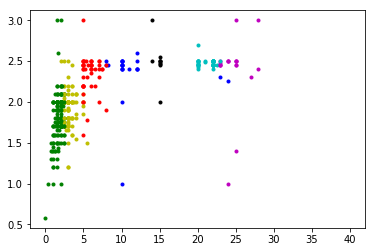

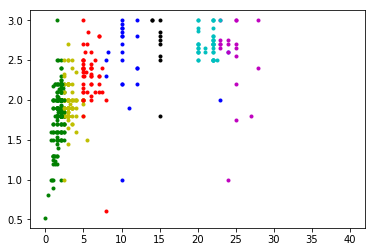

In [338]:
af = AffinityPropagation(preference=-80).fit(new_data)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b', 'g']
predictions = af.fit_predict(new_data)
dots = []
i = 0
for index, row in new_data.iterrows():
    dots.append((row, colors[predictions[i]]))
    i += 1

for dot in dots:
    plt.plot([dot[0]['capacity']], dot[0]['length'],'.', color=dot[1])
plt.show()

for dot in dots:
    plt.plot([dot[0]['capacity']], dot[0]['width'],'.', color=dot[1])
plt.show()

for dot in dots:
    plt.plot([dot[0]['capacity']], dot[0]['height'],'.', color=dot[1])
plt.show()

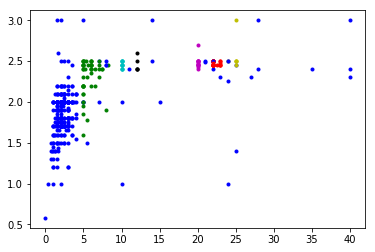

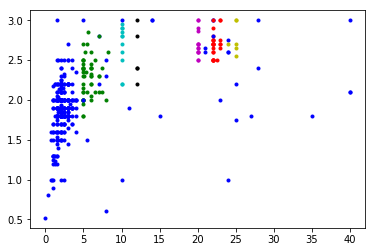

In [339]:
af = DBSCAN(eps=1).fit(new_data)

# n_clusters_ = len(cluster_centers_indices)
# print(n_clusters_)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b']
predictions = af.fit_predict(new_data)
dots = []
i = 0
for index, row in new_data.iterrows():
    dots.append((row, colors[predictions[i]]))
    i += 1

for dot in dots:
    plt.plot([dot[0]['capacity']], dot[0]['length'],'.', color=dot[1])
plt.show()

for dot in dots:
    plt.plot([dot[0]['capacity']], dot[0]['width'],'.', color=dot[1])
plt.show()

for dot in dots:
    plt.plot([dot[0]['capacity']], dot[0]['height'],'.', color=dot[1])
plt.show()

Из предложенных в scikit методов кластеризации для более детального осмотра были выбраны AffinityPropagation и DBSCAN. Выбор был сделан на основании визуального представления возможностей методов на скоплениях данных разных форм. Кроме того, что возможности кластеризации у этих методов отличаются на скоплениях данных определенного представления, для текущей "простой" формы скопления данных методы также отработали по-разному. с точки зрения применения, эти методы отличаются по способу определения и построения кластеров. Так, метод DBSCAN требует в качестве минимального параметра настройки только точности кластеризации, а у метода AffinityPropagation - своя хитрая метрика на специальной числовой характеристике preference. Итого, более четкую и однозначную кластеризацию для конкретного набора данных показал метод AffinityPropagation. Поскольку результат кластеризации этих данных примерно предсказуем, число preference выбиралось эмпирически, чтобы итоговые кластеры(и их количество) соответствовали действительности.